# generate thz data

Alice path loss: 591.57 dB
Eve path loss: 539.80 dB


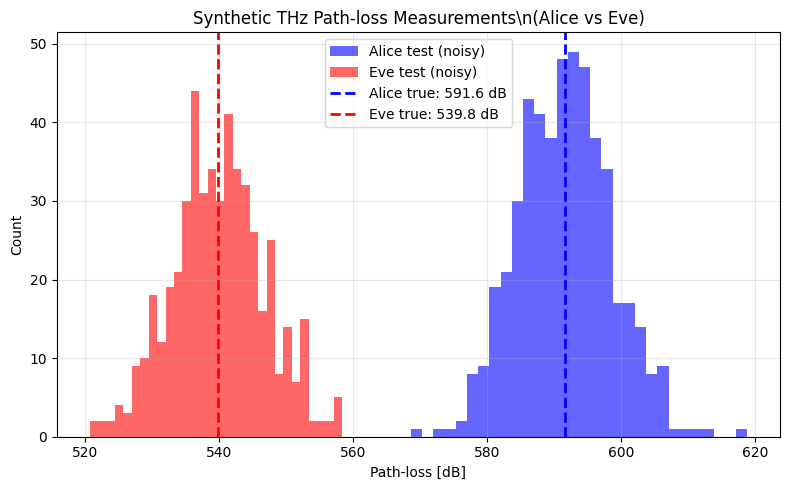

\nSummary Statistics:
Alice test - Mean: 591.61 dB, Std: 6.94 dB
Eve test   - Mean: 540.03 dB, Std: 6.91 dB
\nFiles saved in 'data/' directory:
  - alice_train.csv (training data)
  - alice_test.csv  (test data)
  - eve_test.csv    (test data)
  - thz_data_hist.png (visualization)


In [3]:
#!/usr/bin/env python3
"""
generate_thz_data.py
Create synthetic THz path-loss data that follow the empirical model
  PL(d,f,N) [dB] = -0.2N + 3.98
                 + (0.44N + 98.48) d^0.65
                 + (0.068N + 2.4)  f^4.07
and save three CSV files:
  alice_train.csv   – clean training data (Alice → Bob)
  alice_test.csv    – noisy test data (Alice → Bob)
  eve_test.csv      – noisy test data (Eve  → Bob)
A companion Jupyter / Matplotlib figure is also produced.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------
# Parameters taken from the paper
# --------------------------------------------------
f_THz   = 1.2          # centre frequency [THz]
N       = 4            # #sweat ducts
d_AB_mm = 15.0         # Alice–Bob distance
d_EB_mm = 13.0         # Eve–Bob  distance (close but ≠ d_AB)

sigma_dB = 7.07        # std-dev of measurement noise (≈7 dB)

n_train = 500          # #training packets
n_test  = 500          # #test packets (each link)

out_dir = Path("data")
out_dir.mkdir(exist_ok=True)

# --------------------------------------------------
# Path-loss model (paper eq-1)
# --------------------------------------------------
def pathloss(d_mm, f_THz, N):
    """Return path-loss in dB."""
    return (-0.2*N + 3.98) \
           + (0.44*N + 98.48)*np.power(d_mm, 0.65) \
           + (0.068*N + 2.4)*np.power(f_THz, 4.07)

# --------------------------------------------------
# Create data sets
# --------------------------------------------------
np.random.seed(42)

# Calculate true path losses
pl_AB = pathloss(d_AB_mm, f_THz, N)
pl_EB = pathloss(d_EB_mm, f_THz, N)

print(f"Alice path loss: {pl_AB:.2f} dB")
print(f"Eve path loss: {pl_EB:.2f} dB")

# --- Training (Alice only, noise-free) ---
df_train = pd.DataFrame({
    "true_pl": [pl_AB] * n_train,
    "meas_pl": [pl_AB] * n_train,  # No noise for training
    "label": ["Alice"] * n_train
})
df_train.to_csv(out_dir / "alice_train.csv", index=False)

# --- Test (Alice) ---
noise_A = np.random.normal(0, sigma_dB, n_test)
df_A = pd.DataFrame({
    "true_pl": [pl_AB] * n_test,
    "meas_pl": pl_AB + noise_A,  # Add noise
    "label": ["Alice"] * n_test
})
df_A.to_csv(out_dir / "alice_test.csv", index=False)

# --- Test (Eve) ---
noise_E = np.random.normal(0, sigma_dB, n_test)
df_E = pd.DataFrame({
    "true_pl": [pl_EB] * n_test,
    "meas_pl": pl_EB + noise_E,  # Add noise
    "label": ["Eve"] * n_test
})
df_E.to_csv(out_dir / "eve_test.csv", index=False)

# --------------------------------------------------
# Quick visual sanity check
# --------------------------------------------------
plt.figure(figsize=(8, 5))

# Plot histograms
plt.hist(df_A.meas_pl, bins=30, alpha=0.6, label="Alice test (noisy)", color='blue')
plt.hist(df_E.meas_pl, bins=30, alpha=0.6, label="Eve test (noisy)", color='red')

# Add vertical lines for true values
plt.axvline(pl_AB, color='blue', ls='--', linewidth=2, label=f"Alice true: {pl_AB:.1f} dB")
plt.axvline(pl_EB, color='red', ls='--', linewidth=2, label=f"Eve true: {pl_EB:.1f} dB")

plt.xlabel("Path-loss [dB]")
plt.ylabel("Count")
plt.title("Synthetic THz Path-loss Measurements\\n(Alice vs Eve)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(out_dir / "thz_data_hist.png", dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"\\nSummary Statistics:")
print(f"Alice test - Mean: {df_A.meas_pl.mean():.2f} dB, Std: {df_A.meas_pl.std():.2f} dB")
print(f"Eve test   - Mean: {df_E.meas_pl.mean():.2f} dB, Std: {df_E.meas_pl.std():.2f} dB")
print(f"\\nFiles saved in '{out_dir}/' directory:")
print("  - alice_train.csv (training data)")
print("  - alice_test.csv  (test data)")
print("  - eve_test.csv    (test data)")
print("  - thz_data_hist.png (visualization)")